# Réseau récurrent pour la prévision de données temporelles

L'objectif de ce notebook est de construire un réseau récurrent simple (sans module LSTM ou GRU) permettant de faire de la prévision méteo à partir de données de température, pression et humidité mesurées pendant 5 ans.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN,LSTM,GRU, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

## Données

Les [données](https://www.kaggle.com/selfishgene/historical-hourly-weather-data) sont des mesures de divers paramètres relatifs à la météo (températire, pression, humidité relative) acquis chaque heure entre 2012 et 2017 dans 36 villes (US, Canada et quelques autres grandes villes du monde)

In [2]:
humidity = pd.read_csv("/content/humidity.csv")


In [3]:
ville='Montreal'
humidity_M = humidity[['datetime',ville]]

### Données d'entraînement


Quelques mesures sont manquantes. Plutôt que de les éliminer, on choisit d'interpoler les points (les variations des paramètres étant relativement lents)

In [4]:
print(humidity_M.isna().sum()[ville],"données manquantes d'humidité sur",humidity_M.shape[0])

1696 données manquantes d'humidité sur 45253
3 données manquantes de température sur 45253
994 données manquantes de pression sur 45253


In [5]:
humidity_M.interpolate(inplace=True)
humidity_M.dropna(inplace=True)


Les données d'entraînement sont constituées de `nb_samples` points de mesure, pris au début des données. la prévision se fera sur les 45253-`nb_samples`points restants, on normalise ces données

In [47]:
nb_samples = 5000


scaler_input = MinMaxScaler()



humidity_train = scaler_input.fit_transform(np.array(humidity_M[ville][:nb_samples]).ravel().reshape(-1,1))
humidity_test =  scaler_input.fit_transform(np.array(humidity_M[ville][nb_samples:]).ravel().reshape(-1,1))

In [39]:
def plot_train_points(ville=ville,nb_samples=nb_samples):
    plt.figure(figsize=(15,3))

    plt.title("Humidité à {0:s} sur les {1:d} premiers points".format(ville,nb_samples))
    plt.grid(True)

    plt.plot(scaler_input.inverse_transform(humidity_train.reshape(-1,1)),c='r',lw=1)


    plt.tight_layout()

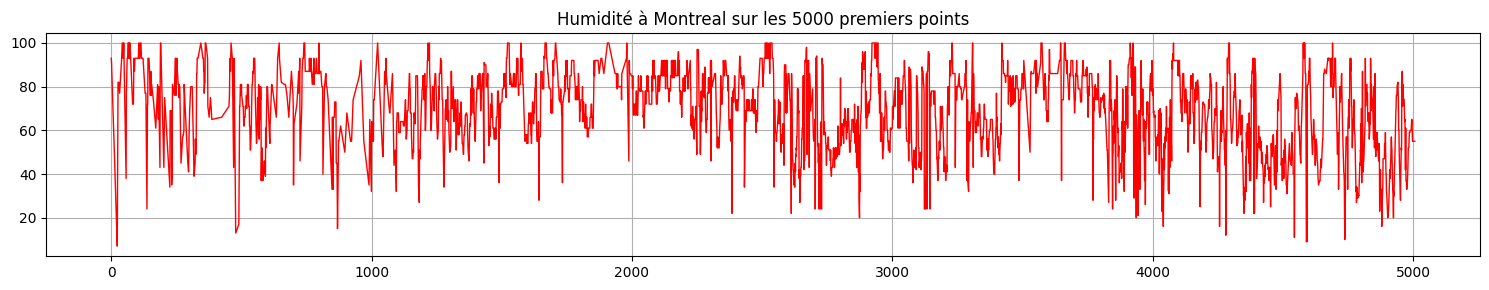

In [40]:
plot_train_points()

### Transformation des données pour le RNN

Un réseau récurrent prédit une valeur à partir des $n$ précédentes, n étant appelé l'embedding size.

In [41]:
embedding_size = 8
saved=False




humidity_train = np.append(humidity_train,np.repeat(humidity_train[-1,],embedding_size))
humidity_test = np.append(humidity_test,np.repeat(humidity_test[-1,],embedding_size))


On convertit ensuite les données sous forme matricielle

In [42]:
def convertToMatrix(data, embedding_size):
    X, Y =[], []
    for i in range(len(data)-embedding_size):
        d=i+embedding_size
        X.append(data[i:d,])
        Y.append(data[d,])
    X=np.array(X)
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    Y=np.array(Y)
    return X,Y

In [43]:
humidity_trainX,humidity_trainY =convertToMatrix(humidity_train,embedding_size)
humidity_testX,humidity_testY =convertToMatrix(humidity_test,embedding_size)

## Réseau récurrent

On  utilise un RNN complètement connecté [(SimpleRNN de Keras)](https://keras.io/layers/recurrent/) suivi d'une sortie réelle (la prédiction)

In [23]:
def myRNN():
    model = Sequential()
    model.add(SimpleRNN(128,activation = "relu"))
    model.add(Dense(32,activation = "relu"))
    model.add(Dense(1,activation = "relu"))

    optimizer = RMSprop(learning_rate=0.0005)

    model.compile(loss=mean_squared_error, optimizer=optimizer, metrics=mean_squared_error)

    return model

model_humidity = myRNN()

### Entraînement

In [24]:
batch_size=8
num_epochs = 100

class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(epoch% 10==0):
          print(str(epoch) + " mse: " + str(logs.get('mean_squared_error')))

Entraînement Humidité
[[[0.92473118 0.90322581 0.86021505 ... 0.74193548 0.69892473 0.65591398]]

 [[0.90322581 0.86021505 0.82795699 ... 0.69892473 0.65591398 0.61290323]]

 [[0.86021505 0.82795699 0.78494624 ... 0.65591398 0.61290323 0.58064516]]

 ...

 [[0.56989247 0.51612903 0.51612903 ... 0.51612903 0.51612903 0.51612903]]

 [[0.51612903 0.51612903 0.51612903 ... 0.51612903 0.51612903 0.51612903]]

 [[0.51612903 0.51612903 0.51612903 ... 0.51612903 0.51612903 0.51612903]]]
0 mse: 0.011274808086454868
10 mse: 0.007221696432679892
20 mse: 0.00698955450206995
30 mse: 0.006802911404520273
40 mse: 0.006670928094536066
50 mse: 0.006607643328607082
60 mse: 0.006534736603498459
70 mse: 0.006426893640309572
80 mse: 0.006425331812351942
90 mse: 0.00640110531821847


Text(0.5, 1.0, 'RMSE Humidité')

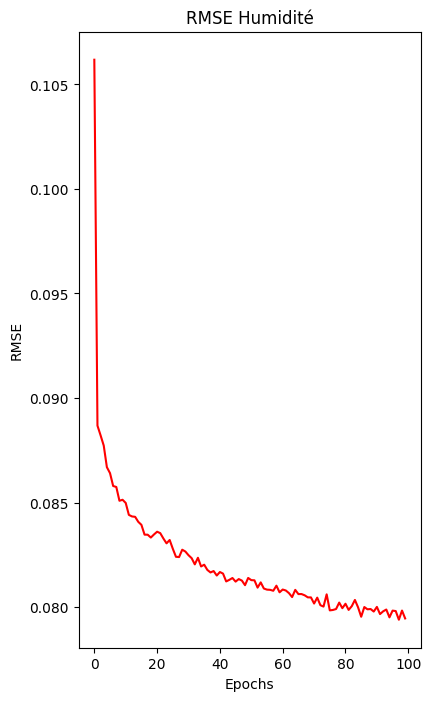

In [25]:
# Si déjà entrainé
#model_humidity.load_weights("model_humidity.h5")


print('Entraînement Humidité')
print(humidity_trainX)
model_humidity.fit(humidity_trainX,humidity_trainY, epochs=num_epochs,
          batch_size=8, callbacks=[MyCallback()],verbose=0)
plt.figure(figsize=(15,8))
plt.subplot(131)
plt.plot(np.sqrt(model_humidity.history.history['loss']),c='r')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title('RMSE Humidité')



In [44]:
model_humidity.save_weights("model_humidity.h5")

## Prédiction

In [57]:
humidity_predicted = np.concatenate((model_humidity.predict(humidity_trainX),
                                   model_humidity.predict( humidity_testX)),axis=0)


1259/1259 [==============================] - 3s 3ms/step


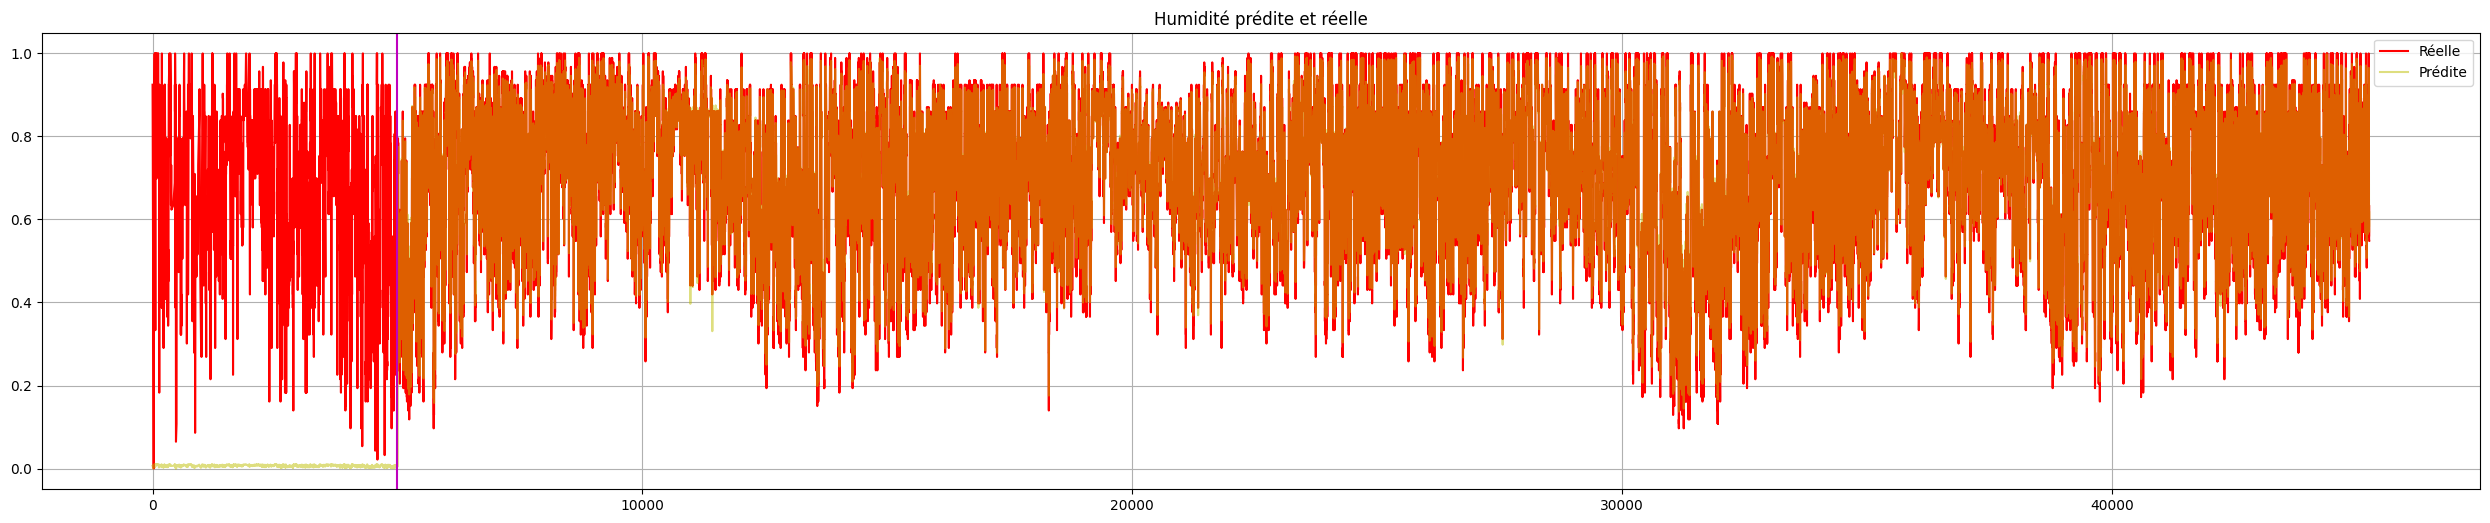

In [97]:

plt.figure(figsize=(25,15))

plt.subplot(311)
index = humidity_M.index.values
plt.title("Humidité prédite et réelle")
plt.plot(index,scaler_input.fit_transform(humidity_M[ville].values.reshape(-1, 1)),'r')
plt.plot(index,scaler_input.fit_transform(humidity_predicted[:45252]),'y',alpha=0.5)
plt.legend(['Réelle','Prédite'])
plt.axvline(x=nb_samples, c='m')
plt.grid(True)

plt.tight_layout()


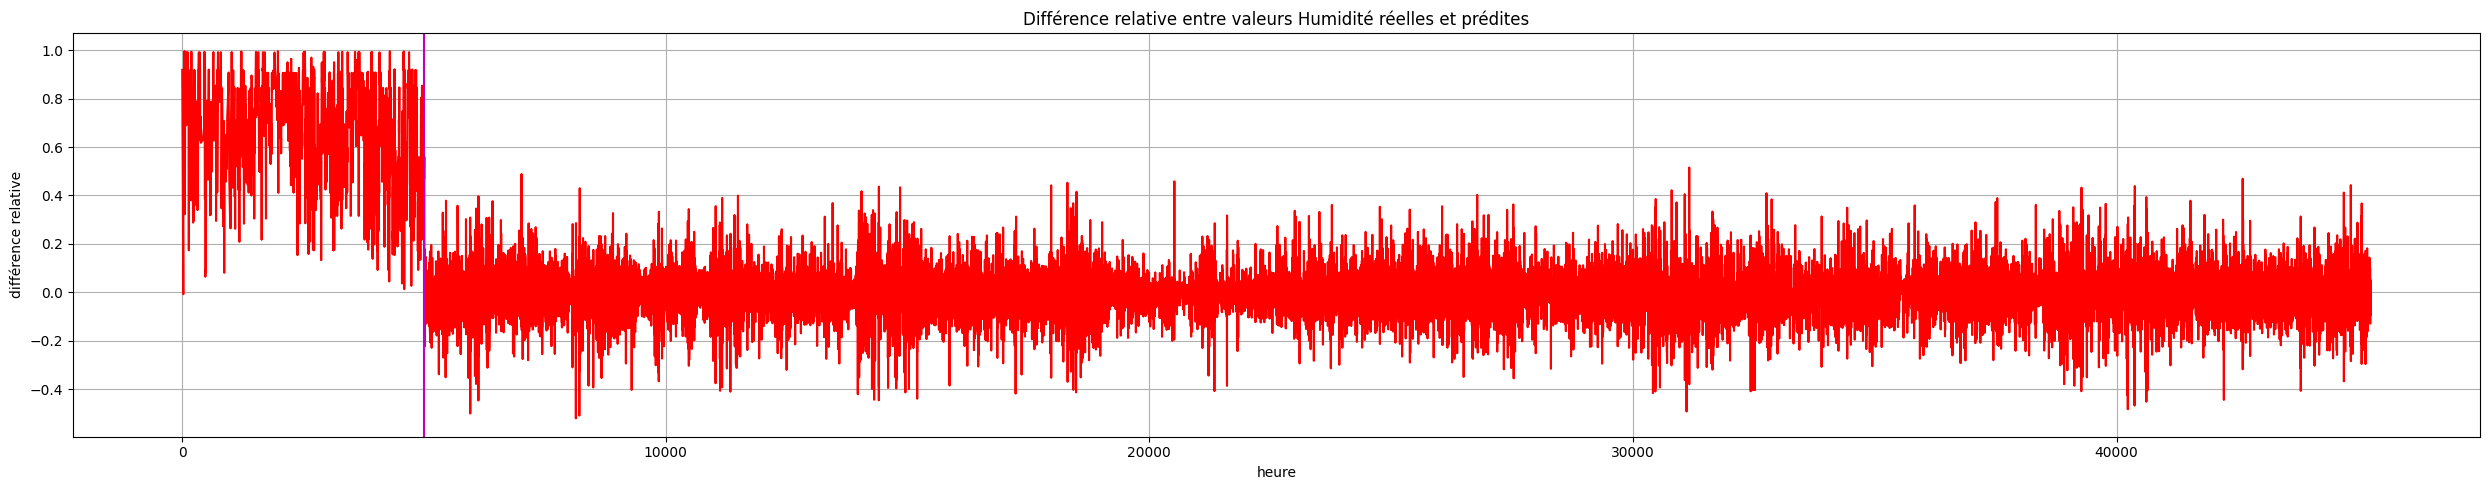

In [98]:
plt.figure(figsize=(25,5))

plt.title("Différence relative entre valeurs Humidité réelles et prédites")
plt.plot(index ,scaler_input.fit_transform(humidity_M[ville].values.reshape(-1, 1)) - scaler_input.fit_transform(humidity_predicted[:45252]),'r')
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)



plt.tight_layout()

### Comparaison aux réseaux LSTM et GRU


#### Comparaison LSTM

In [93]:
np.random.seed(42)


def last_time_step_mse(Y_true, Y_pred):
    return mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


modelLSTM = Sequential()
modelLSTM.add(LSTM(128,activation = "relu"))
modelLSTM.add(Dense(32,activation = "relu"))
modelLSTM.add(Dense(1,activation = "relu"))

optimizer = RMSprop(learning_rate=0.0005)

modelLSTM.compile(loss=mean_squared_error, optimizer=optimizer, metrics=mean_squared_error)


modelLSTM.fit(humidity_trainX,humidity_trainY, epochs=num_epochs,
          batch_size=8, callbacks=[MyCallback()],verbose=0)

0 mse: 0.023838577792048454
10 mse: 0.007324707228690386
20 mse: 0.007106647826731205
30 mse: 0.007013815455138683
40 mse: 0.006895785219967365
50 mse: 0.006857773754745722
60 mse: 0.00678414897993207
70 mse: 0.006698776967823505
80 mse: 0.006723759695887566
90 mse: 0.006533524487167597


In [94]:
humidity_predictedLSTM=np.concatenate((modelLSTM.predict(humidity_trainX),
                                   modelLSTM.predict(humidity_testX)),axis=0)
humidity_predictedLSTM = scaler_input.fit_transform(humidity_predictedLSTM)

1259/1259 [==============================] - 3s 3ms/step


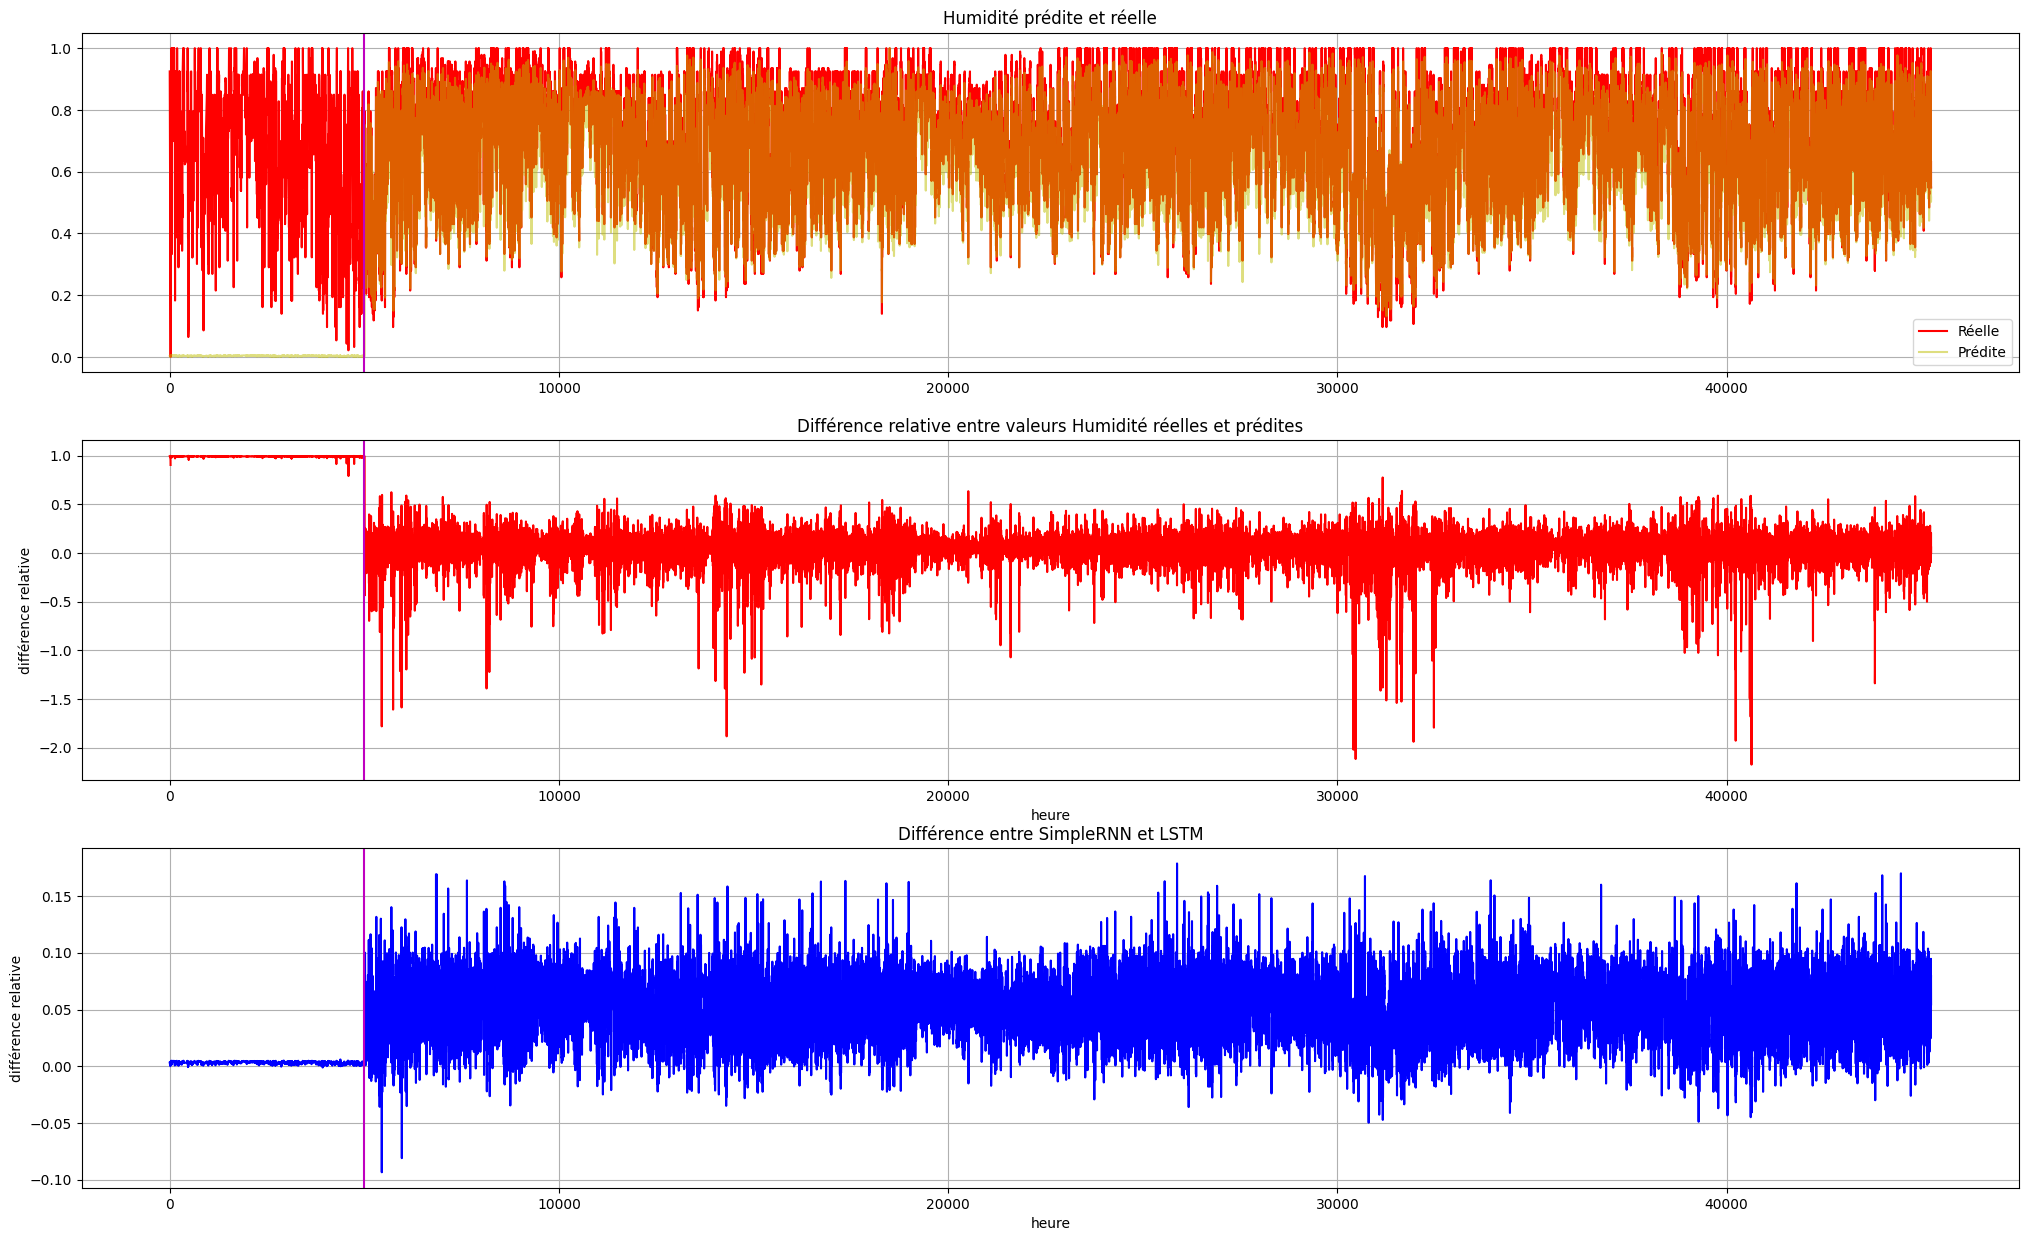

In [103]:
plt.figure(figsize=(25,15))


plt.subplot(311)
index = humidity_M.index.values
plt.title("Humidité prédite et réelle")
plt.plot(index,scaler_input.fit_transform(humidity_M[ville].values.reshape(-1, 1)),'r')
plt.plot(index,scaler_input.fit_transform(humidity_predictedLSTM[:45252]),'y',alpha=0.5)
plt.legend(['Réelle','Prédite'])
plt.axvline(x=nb_samples, c='m')
plt.grid(True)

plt.subplot(312)
index = humidity_M.index.values
x = scaler_input.fit_transform(np.array(humidity_M[ville]).reshape(-1,1))
max = np.max(x)
plt.title("Différence relative entre valeurs Humidité réelles et prédites")
plt.plot(index,(x-scaler_input.fit_transform(humidity_predictedLSTM[:45252]))/x,'r')
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)
plt.subplot(313)
plt.title("Différence entre SimpleRNN et LSTM")
plt.plot(index,(scaler_input.fit_transform(humidity_predicted[:45252])-scaler_input.fit_transform(humidity_predictedLSTM[:45252])),'b')
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)

#### Comparaison GRU

In [96]:
np.random.seed(42)

def last_time_step_mse(Y_true, Y_pred):
    return mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


modelGRU = Sequential()
modelGRU.add(GRU(128,activation = "relu"))
modelGRU.add(Dense(32,activation = "relu"))
modelGRU.add(Dense(1,activation = "relu"))

optimizer = RMSprop(learning_rate=0.0005)

modelGRU.compile(loss=mean_squared_error, optimizer=optimizer, metrics=mean_squared_error)


modelGRU.fit(humidity_trainX,humidity_trainY, epochs=num_epochs,
          batch_size=8, callbacks=[MyCallback()],verbose=0)

0 mse: 0.01923626847565174
10 mse: 0.0073236823081970215
20 mse: 0.007088636048138142
30 mse: 0.0069231451489031315
40 mse: 0.006817581597715616
50 mse: 0.006700577214360237
60 mse: 0.006605434697121382
70 mse: 0.006618955172598362
80 mse: 0.00653013726696372
90 mse: 0.006491638254374266


In [108]:
humidity_predictedGRU=np.concatenate((modelGRU.predict(humidity_trainX),
                                   modelGRU.predict(humidity_testX)),axis=0)
humidity_predictedGRU = humidity_predictedGRU.reshape(-1,1)

1259/1259 [==============================] - 3s 2ms/step


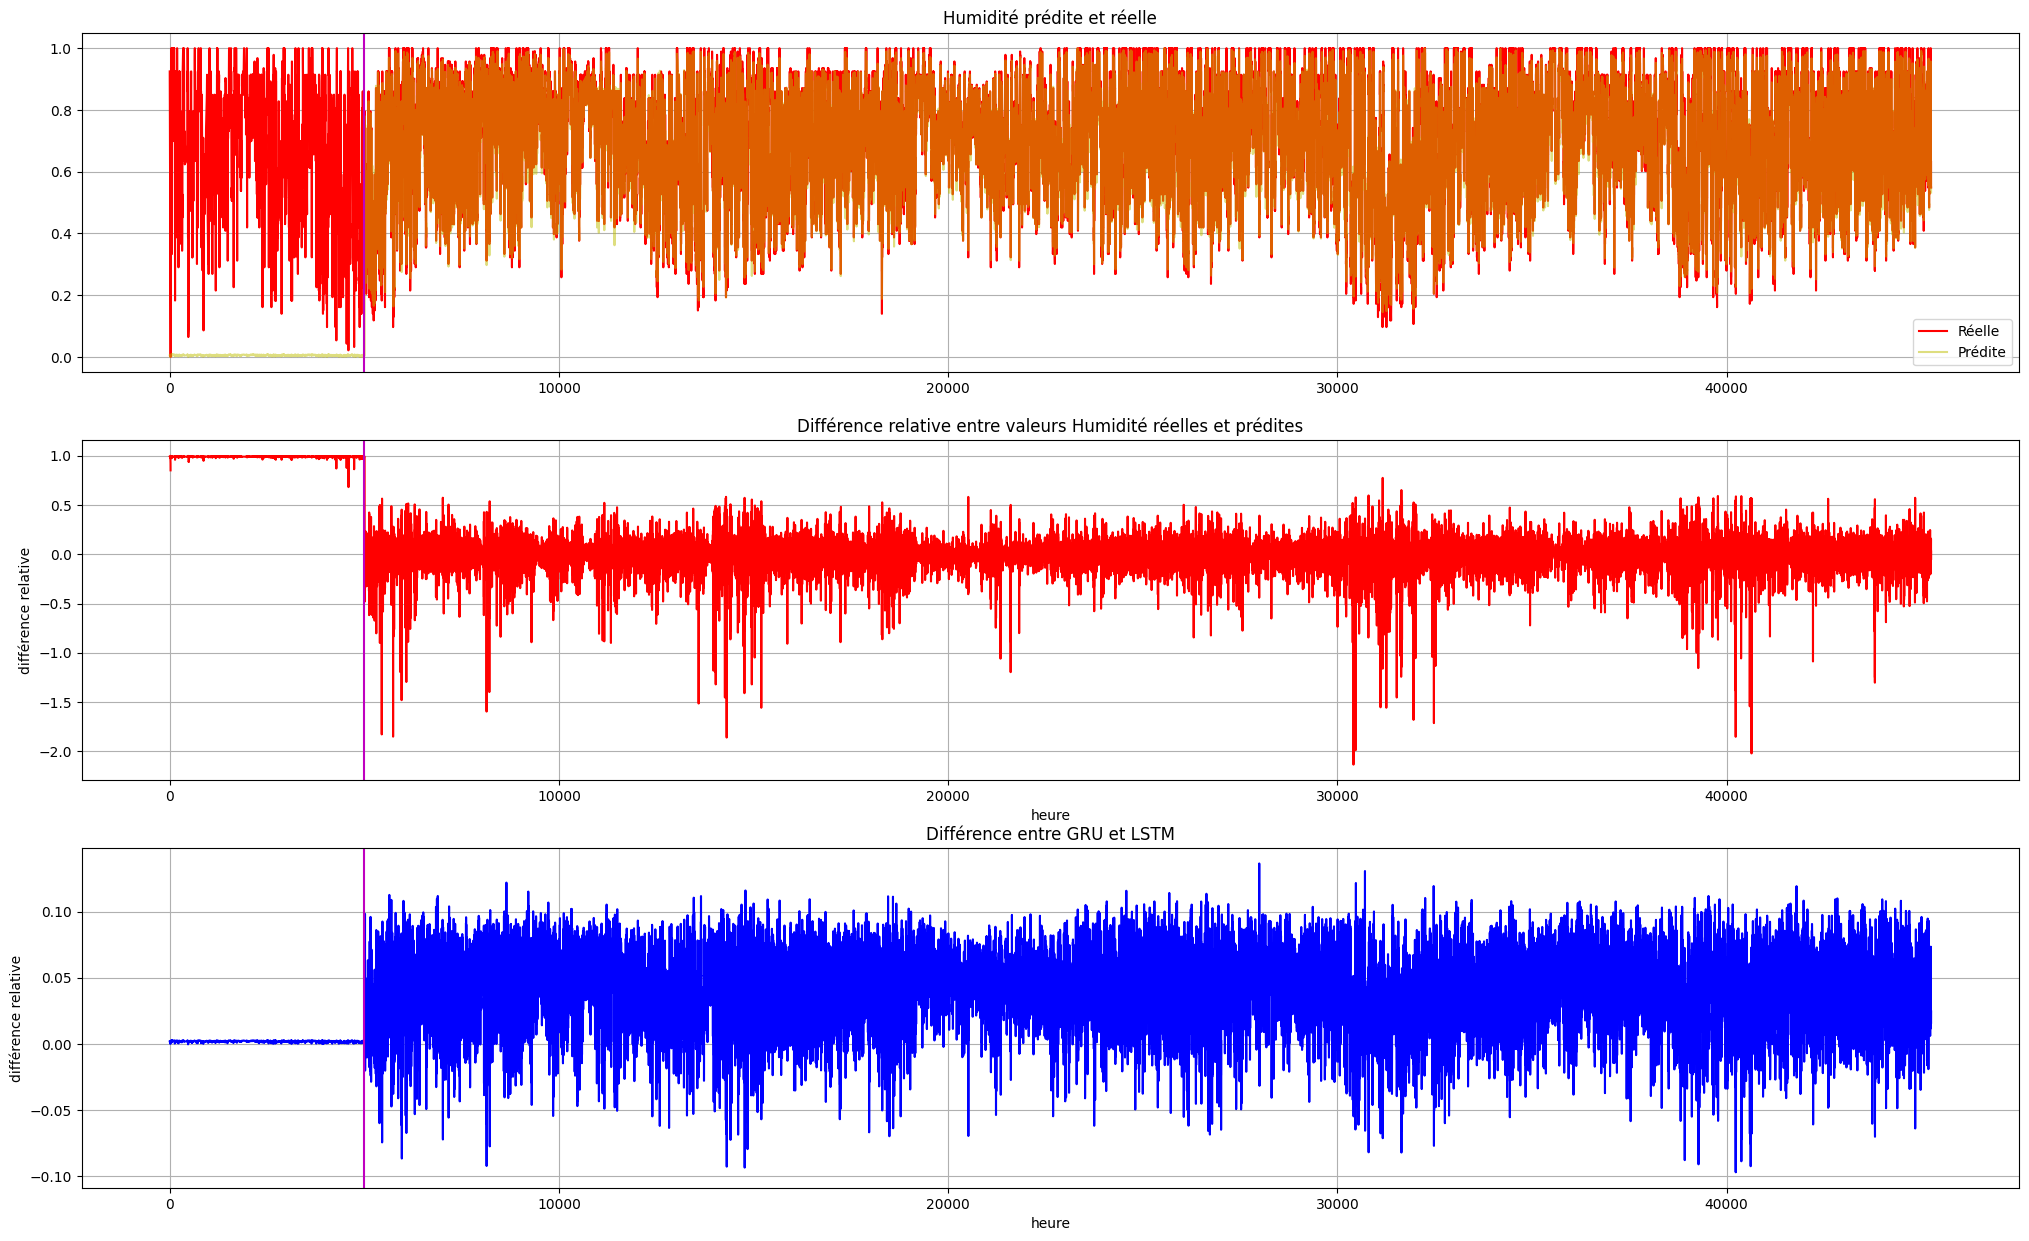

In [112]:
plt.figure(figsize=(25,15))


plt.subplot(311)
index = humidity_M.index.values
plt.title("Humidité prédite et réelle")
plt.plot(index,scaler_input.fit_transform(humidity_M[ville].values.reshape(-1, 1)),'r')
plt.plot(index,scaler_input.fit_transform(humidity_predictedGRU[:45252]),'y',alpha=0.5)
plt.legend(['Réelle','Prédite'])
plt.axvline(x=nb_samples, c='m')
plt.grid(True)

plt.subplot(312)
index = humidity_M.index.values
x = scaler_input.fit_transform(np.array(humidity_M[ville]).reshape(-1,1))
max = np.max(x)
plt.title("Différence relative entre valeurs Humidité réelles et prédites")
plt.plot(index,(x-scaler_input.fit_transform(humidity_predictedGRU[:45252]))/x,'r')
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)
plt.subplot(313)
plt.title("Différence entre GRU et LSTM")
plt.plot(index,(scaler_input.fit_transform(humidity_predictedGRU[:45252])-scaler_input.fit_transform(humidity_predictedLSTM[:45252])),'b')
plt.xlabel('heure')
plt.ylabel('différence relative')
plt.axvline(x=nb_samples, c="m")
plt.grid(True)